In [180]:
import json
import pandas as pd
import numpy as np

w = 8
FIGSIZE = (w, w/1.618)
FP_LOGINS = 'logins.json'

In [2]:
with open(FP_LOGINS, 'r') as f:
    logins = json.loads(f.read())

# Exploratory Data Analysis

We'll start by flooring the timestamps to 15 minutes:

In [3]:
BASE_DATA = pd.DataFrame({'time':logins['login_time']})
BASE_DATA['time'] = pd.to_datetime(BASE_DATA['time'])
BASE_DATA = BASE_DATA.sort_values(by=['time']).reset_index(drop=True)
BASE_DATA['time_floor'] = BASE_DATA['time'].dt.floor('15min')
print(BASE_DATA.shape)
BASE_DATA.head(10)

(93142, 2)


,time,time_floor
0,1970-01-01 20:12:16,1970-01-01 20:00:00
1,1970-01-01 20:13:18,1970-01-01 20:00:00
2,1970-01-01 20:16:10,1970-01-01 20:15:00
3,1970-01-01 20:16:36,1970-01-01 20:15:00
4,1970-01-01 20:16:37,1970-01-01 20:15:00
5,1970-01-01 20:21:41,1970-01-01 20:15:00
6,1970-01-01 20:26:05,1970-01-01 20:15:00
7,1970-01-01 20:26:21,1970-01-01 20:15:00
8,1970-01-01 20:31:03,1970-01-01 20:30:00
9,1970-01-01 20:34:46,1970-01-01 20:30:00


...next we'll aggregate the count of logins by time interval:

In [31]:
df = (BASE_DATA.groupby('time_floor').count().reset_index(drop=False)
               .rename(columns={'time_floor':'time', 'time':'count'})
               .sort_values(by=['time']))

df['hour'] = df['time'].dt.strftime('%H')
df['month'] = df['time'].dt.strftime('%B')
df['year'] = df['time'].dt.strftime('%Y')
df = df[['time', 'year', 'month', 'hour', 'count']].copy()
df.head(25)

,time,year,month,hour,count
0,1970-01-01 20:00:00,1970,January,20,2
1,1970-01-01 20:15:00,1970,January,20,6
2,1970-01-01 20:30:00,1970,January,20,9
3,1970-01-01 20:45:00,1970,January,20,7
4,1970-01-01 21:00:00,1970,January,21,1
5,1970-01-01 21:15:00,1970,January,21,4
6,1970-01-01 21:45:00,1970,January,21,4
7,1970-01-01 22:00:00,1970,January,22,9
8,1970-01-01 22:15:00,1970,January,22,8
9,1970-01-01 22:30:00,1970,January,22,1


Note that we only have data for four months:

In [32]:
df.groupby(['year', 'month']).sum('count')

count
year month          
1970 April     13507
     February  24673
     January   21239
     March     33723

In the below graph, we have the number of logins by the hour of day:

<Axes: title={'center': 'Login Count by Hour of Day'}, xlabel='hour'>

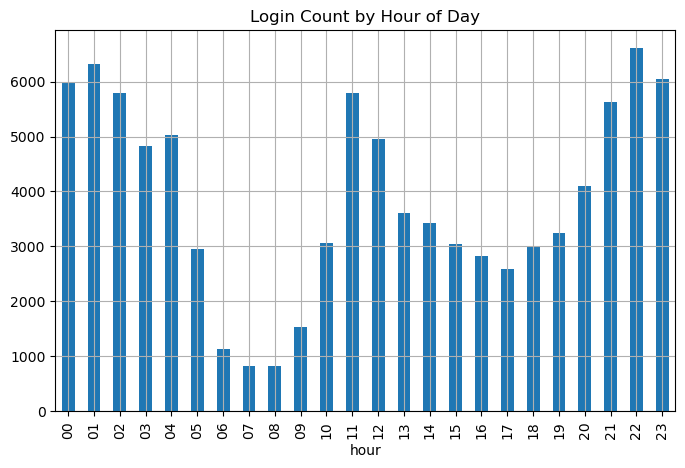

In [28]:
gr = df.groupby('hour').sum('count')
title = 'Login Count by Hour of Day'
gr['count'].plot(kind='bar', figsize=FIGSIZE, grid=True, title=title)

... and we can see clearly that the most logins are from about 19:00 through 04:00 the next day, and there is another increase in logins between 09:00 and 15:00. Between 06:00 and 10:00 is a period of fewer logins and 15:00 to 19:00 is more logins. 

# Experiment and Metrics Design

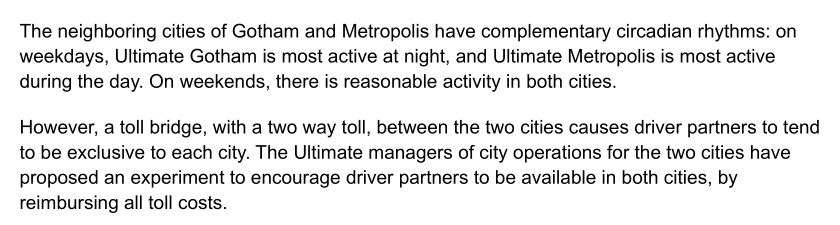

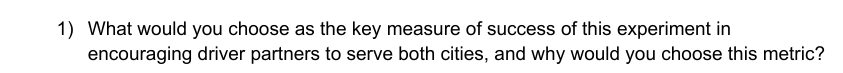

The key metric of success in this experiment should be the proportion of driver partners who operate in both cities; comparing this number to before the experiment and after. This metric should be used because it directly measures the desired outcome - the goal is to increase driver availibility in both cities and this metric measures this directly. 

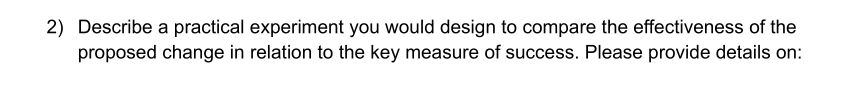

First, we'll collect data on the number of drivers who are operating in both cities. Then, the toll program will be implemented, and the same metric will be measured again for comparable period of time after the toll program is introduced. A standard T-test of proportions will evaluate if this difference is statistically significant.

# Data Prep

First, we'll load our data and provide 

In [224]:
fp = 'ultimate_data_challenge.json'
with open(fp, 'r') as f:
    data = json.loads(f.read())

df = pd.DataFrame(data)
for col in ['signup_date', 'last_trip_date']:
    df[col] = pd.to_datetime(df[col])

# determine if user was active after 6mos or not 
# (code is expanded below for clarity)
#     add 6 months 
#     subtract 30 days since the user is considered active if the took a trip in the past 30 days 
df['retention_date'] = df['signup_date'] \
    + pd.Timedelta(days=6*30) \
    - pd.Timedelta(days=30) 
df['survived'] = df['last_trip_date'] > df['retention_date']
df = df.sort_values(by=['signup_date']).reset_index(drop=True)

cols = ['signup_date', 'last_trip_date', 'retention_date', 'survived']
df[cols].sample(15, random_state=42)

,signup_date,last_trip_date,retention_date,survived
33553,2014-01-22,2014-03-30,2014-06-21,False
9427,2014-01-07,2014-06-30,2014-06-06,True
199,2014-01-01,2014-06-08,2014-05-31,True
12447,2014-01-09,2014-06-16,2014-06-08,True
39489,2014-01-25,2014-06-29,2014-06-24,True
42724,2014-01-27,2014-01-29,2014-06-26,False
10822,2014-01-08,2014-06-08,2014-06-07,True
49498,2014-01-31,2014-01-31,2014-06-30,False
4144,2014-01-04,2014-03-05,2014-06-03,False
36958,2014-01-24,2014-06-23,2014-06-23,False


We need to make sure that our code is behaving as expected. Let's write a quick throwaway function which calculates whether or not the user is active for one sample (separately from the above code) and details this calculation. We'll use this to spot check some samples, just to scan for any issues that might impact a large number of records:

In [225]:
def inspect_one(idx):
    global df
    fd = lambda x: x.strftime('%Y-%m-%d')
    days = (df.loc[idx, 'last_trip_date'] - df.loc[idx, 'signup_date']).days
    signup_plus_6mos = df.loc[idx, 'signup_date'] + pd.Timedelta(days=30*6)
    ltd = df.loc[idx, 'last_trip_date']
    thre = signup_plus_6mos - pd.Timedelta(days=30)
    survived = 'active' if ltd > thre else 'inactive'
    before = 'after' if ltd > thre else 'before'
    x = 'active' if df.loc[idx, 'survived'] else 'inactive'
    problem = 'there appears to be a problem with how this sample is labeled' if survived != x else 'this labeling seems to be okay for this sample'
    
    msg = f"""
    for dataframe index {idx}:
    
    * {fd(df.loc[idx, 'signup_date'])} - signup date
    * {fd(df.loc[idx, 'last_trip_date'])} - last trip date
    * There are {days} days between these two dates, or about {days/30:.1f} months. 
    * Six months after the signup date would be {fd(signup_plus_6mos)}
    * Users are active if took trip in past 30 days, therefore the retention threshold is {fd(thre)}
    * This user's last trip was taken on {fd(ltd)}
    * The last trip date is {before} the threshold date, therefore this user is {survived} 
    * In the project dataframe, this user is labeled as {x} 

    "{survived}" - local label (calculated here)
    "{x}" - label in dataframe (calculated w/ vectorized operations in pandas) 

    {problem}
    
    """
    
    print(msg)

...let's review 5 samples:

In [226]:
for idx in df.sample(5, random_state=42).index:
    inspect_one(idx)


    for dataframe index 33553:
    
    * 2014-01-22 - signup date
    * 2014-03-30 - last trip date
    * There are 67 days between these two dates, or about 2.2 months. 
    * Six months after the signup date would be 2014-07-21
    * Users are active if took trip in past 30 days, therefore the retention threshold is 2014-06-21
    * This user's last trip was taken on 2014-03-30
    * The last trip date is before the threshold date, therefore this user is inactive 
    * In the project dataframe, this user is labeled as inactive 

    "inactive" - local label (calculated here)
    "inactive" - label in dataframe (calculated w/ vectorized operations in pandas) 

    this labeling seems to be okay for this sample
    
    

    for dataframe index 9427:
    
    * 2014-01-07 - signup date
    * 2014-06-30 - last trip date
    * There are 174 days between these two dates, or about 5.8 months. 
    * Six months after the signup date would be 2014-07-06
    * Users are active if took tri

Okay, we've successfully derived the outcome variable (`survived` in `df`), i.e. we'll be predicting this variable. 

Let's look at the distribution of the outcome variable:

In [227]:
x = df['survived'].value_counts(dropna=False)
print(x)
print()
print(x / x.sum())

survived
False    37802
True     12198
Name: count, dtype: int64

survived
False    0.75604
True     0.24396
Name: count, dtype: float64


...we can work with this! About 25% of users were retained. 

Now, we'll create a list of (potential) features and also lists that separate these by continuous or categorical variables:

In [228]:
feats = ['city', 'phone', 'avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 
         'surge_pct', 'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct']

feats_cat = ['city', 'phone', 'ultimate_black_user']
feats_cont = [x for x in feats if x not in feats_cat]
df[feats_cat + feats_cont]

,city,phone,ultimate_black_user,avg_dist,avg_rating_by_driver,avg_rating_of_driver,surge_pct,trips_in_first_30_days,weekday_pct
0,Astapor,iPhone,False,4.03,4.0,NaN,0.0,2,0.0
1,Winterfell,iPhone,True,3.39,5.0,NaN,0.0,1,100.0
2,Winterfell,iPhone,True,9.76,5.0,NaN,0.0,0,66.7
3,Winterfell,Android,False,5.03,4.7,5.0,0.0,2,54.5
4,Winterfell,iPhone,False,3.28,5.0,3.0,100.0,0,0.0
...,...,...,...,...,...,...,...,...,...
49995,Astapor,Android,False,4.53,5.0,4.0,33.3,0,66.7
49996,Winterfell,iPhone,False,7.90,5.0,4.5,0.0,4,80.0
49997,King's Landing,iPhone,True,1.98,4.6,5.0,41.2,0,58.8
49998,King's Landing,iPhone,True,1.90,4.9,5.0,3.0,2,91.0


How many null values do we have:

In [229]:
df.isnull().sum().sort_values() / len(df)

city                      0.00000
trips_in_first_30_days    0.00000
signup_date               0.00000
avg_surge                 0.00000
last_trip_date            0.00000
surge_pct                 0.00000
ultimate_black_user       0.00000
weekday_pct               0.00000
avg_dist                  0.00000
retention_date            0.00000
survived                  0.00000
avg_rating_by_driver      0.00402
phone                     0.00792
avg_rating_of_driver      0.16244
dtype: float64

Column `avg_rating_by_driver` has a small number of null values, (less than 1%), so we can confidently fill these with the mean value; since it is such a small number it won't impact the outcome of the predictive model:

In [230]:
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean())

Also a small number of missing values in the `phone` column, again less than 1%. We'll fill these with the most common value. 

In [231]:
df['phone'].value_counts(dropna=False)

phone
iPhone     34582
Android    15022
None         396
Name: count, dtype: int64

In [232]:
df['phone'] = df['phone'].fillna('iPhone')
df['phone'].value_counts(dropna=False)

phone
iPhone     34978
Android    15022
Name: count, dtype: int64

The average rating of the driver is missing about 16% of values. Such a large percentage makes it hard to justify simply filling the missing value with the mean. Also, it seems like the type of user who doesn't rate the driver could materially different from users who do...so we have a bit of a problem. 

One quick thing we could do is simply turn this into a categorical variable, which makes sense because this is based on a 1-5 scale anyway. 

We'll round these to the nearest half point:

In [233]:
df['avg_rating_of_driver'].describe()

count    41878.000000
mean         4.601559
std          0.617338
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64

In [234]:
df['avg_rating_of_driver_rounded'] = np.round(df['avg_rating_of_driver'] * 2) / 2
df[['avg_rating_of_driver', 'avg_rating_of_driver_rounded']].sample(10)

,avg_rating_of_driver,avg_rating_of_driver_rounded
34474,5.0,5.0
42825,5.0,5.0
35189,4.8,5.0
25916,NaN,NaN
2933,5.0,5.0
6180,NaN,NaN
1910,4.5,4.5
34529,5.0,5.0
44903,NaN,NaN
16719,5.0,5.0


In [235]:
df['avg_rating_of_driver_rounded'].value_counts()

avg_rating_of_driver_rounded
5.0    24972
4.5     7902
4.0     5875
3.5     1333
3.0     1136
1.0      256
2.0      219
2.5      178
1.5        7
Name: count, dtype: int64

...there aren't enough values in the ratings below 3, it just isn't enough data for those subsets to be useful. Let's aggregate together the ratings which are less than 3 (inclusive):

In [236]:
df['driver_rating'] = df['avg_rating_of_driver_rounded'].copy()
sub_three = (df['driver_rating'] <= 3) & (df['driver_rating'].notnull())
null = df['driver_rating'].isnull()
df['driver_rating'] = df['driver_rating'].astype(str)
df.loc[sub_three, 'driver_rating'] = '3-'
df.loc[null, 'driver_rating'] = 'no ratings'

df['driver_rating'].value_counts()

driver_rating
5.0           24972
no ratings     8122
4.5            7902
4.0            5875
3-             1796
3.5            1333
Name: count, dtype: int64

Now let's update the list of features:

In [237]:
feats = ['city', 'phone', 'avg_dist', 'avg_rating_by_driver', 'driver_rating', 
         'surge_pct', 'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct']

feats_cat = ['city', 'phone', 'ultimate_black_user', 'driver_rating']
feats_cont = [x for x in feats if x not in feats_cat]
df[feats_cat + feats_cont]

,city,phone,ultimate_black_user,driver_rating,avg_dist,avg_rating_by_driver,surge_pct,trips_in_first_30_days,weekday_pct
0,Astapor,iPhone,False,no ratings,4.03,4.0,0.0,2,0.0
1,Winterfell,iPhone,True,no ratings,3.39,5.0,0.0,1,100.0
2,Winterfell,iPhone,True,no ratings,9.76,5.0,0.0,0,66.7
3,Winterfell,Android,False,5.0,5.03,4.7,0.0,2,54.5
4,Winterfell,iPhone,False,3-,3.28,5.0,100.0,0,0.0
...,...,...,...,...,...,...,...,...,...
49995,Astapor,Android,False,4.0,4.53,5.0,33.3,0,66.7
49996,Winterfell,iPhone,False,4.5,7.90,5.0,0.0,4,80.0
49997,King's Landing,iPhone,True,5.0,1.98,4.6,41.2,0,58.8
49998,King's Landing,iPhone,True,5.0,1.90,4.9,3.0,2,91.0


...and encode our categorical variables:

In [238]:
for col in feats_cat:
    df[col] = df[col].astype('category').cat.codes
    print(df[col].value_counts())

city
2    23336
0    16534
1    10130
Name: count, dtype: int64
phone
1    34978
0    15022
Name: count, dtype: int64
ultimate_black_user
0    31146
1    18854
Name: count, dtype: int64
driver_rating
4    24972
5     8122
3     7902
2     5875
0     1796
1     1333
Name: count, dtype: int64


Now we have a dataframe that is ready for training:

In [239]:
df[feats]

,city,phone,avg_dist,avg_rating_by_driver,driver_rating,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,0,1,4.03,4.0,5,0.0,2,0,0.0
1,2,1,3.39,5.0,5,0.0,1,1,100.0
2,2,1,9.76,5.0,5,0.0,0,1,66.7
3,2,0,5.03,4.7,4,0.0,2,0,54.5
4,2,1,3.28,5.0,0,100.0,0,0,0.0
...,...,...,...,...,...,...,...,...,...
49995,0,0,4.53,5.0,2,33.3,0,0,66.7
49996,2,1,7.90,5.0,3,0.0,4,0,80.0
49997,1,1,1.98,4.6,4,41.2,0,1,58.8
49998,1,1,1.90,4.9,4,3.0,2,1,91.0


# Model Fitting